In [1]:
import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings("ignore", message="Workbook contains no default style")

file_paths = glob.glob("../data/xlsx/아파트(매매)_경기*.xlsx")

# DataFrames for multiple districts(구)
city_data = {
    "용인": pd.DataFrame(),
    "안양": pd.DataFrame(),
    "수원": pd.DataFrame(),
    "군포": pd.DataFrame(),
    "광주": pd.DataFrame(),
    "의왕": pd.DataFrame(),
    "이천": pd.DataFrame(),
    "하남": pd.DataFrame(),
    "과천": pd.DataFrame(),
    "광명": pd.DataFrame()
}

for file_path in file_paths:
    df = pd.read_excel(file_path, skiprows=12)
    df['거래금액(만원)'] = df['거래금액(만원)'].replace(',', '', regex=True).astype(float)
    df['전용면적(㎡)'] = df['전용면적(㎡)'].replace(',', '', regex=True).astype(int)
    
    for city in city_data.keys():
        if city in file_path:
            city_data[city] = pd.concat([city_data[city], df], ignore_index=True)
            break

# 각 도시별 평균 거래금액 계산
summary_data = []
for city, data in city_data.items():
    if not data.empty:
        avg_price = data['거래금액(만원)'].mean()
        summary_data.append({"도시": city, "평균 거래금액(만원)": round(avg_price, 2)})

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by="평균 거래금액(만원)", ascending=True).reset_index(drop=True)

print("도시별 평균 아파트 가격 :")
print(summary_df)


도시별 평균 아파트 가격 :
   도시  평균 거래금액(만원)
0  이천     24929.09
1  광주     40849.22
2  군포     46843.57
3  수원     55566.72
4  용인     61113.50
5  안양     62342.40
6  의왕     66429.59
7  광명     70022.22
8  하남     88540.53
9  과천    167472.32


/tmp/ipykernel_8635/4213679177.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="도시", y="평균 거래금액(만원)", palette="viridis")


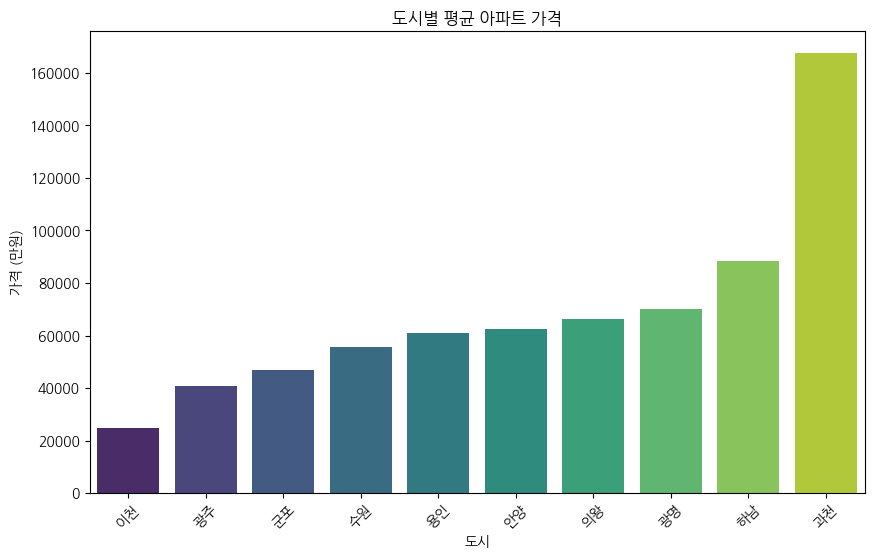

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="도시", y="평균 거래금액(만원)", palette="viridis")
plt.title("도시별 평균 아파트 가격")
plt.xlabel("도시")
plt.ylabel("가격 (만원)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pymysql

connection = pymysql.connect(
    host="db-2030.ctgi4a6mu7iz.ap-northeast-2.rds.amazonaws.com",
    user = "dong",
    passwd="1234",
    database="HSHDB"
)

In [1]:
import pandas as pd
import glob
import pymysql
import warnings
warnings.filterwarnings("ignore", message="Workbook contains no default style")

file_paths = glob.glob("../data/xlsx/아파트(매매)_경기*.xlsx")

gwangju_df = pd.DataFrame()

for file_path in file_paths:
    if '광주' in file_path: 
        df = pd.read_excel(file_path, skiprows=12)  
        
        df['거래금액(만원)'] = df['거래금액(만원)'].replace(',', '', regex=True).astype(float)
        df['전용면적(㎡)'] = df['전용면적(㎡)'].replace(',', '', regex=True).astype(int)
        df = df[((df['전용면적(㎡)'] <= 85) & (df['전용면적(㎡)'] >= 80)) | (df['전용면적(㎡)'] <= 40)]

        gwangju_df = pd.concat([gwangju_df, df], ignore_index=True)

if gwangju_df.empty:
    print("광주 데이터가 없습니다.")
else:
    print("광주 데이터 로드 완료:", gwangju_df.shape)

gwangju_df = gwangju_df.rename(columns={
    '시군구': 'Address',
    '전용면적(㎡)': 'Area',
    '건축년도': 'YearofConstruction',
    '거래금액(만원)': 'SalePrice'
})
gwangju_df = gwangju_df[['Address', 'Area', 'YearofConstruction', 'SalePrice']]

connection = pymysql.connect(
    host="db-2030.ctgi4a6mu7iz.ap-northeast-2.rds.amazonaws.com",
    user="dong",
    passwd="1234",
    database="HSHDB"
)
cursor = connection.cursor()

insert_query = """
INSERT INTO Apartments (Address, Area, yearofConstruction, salePrice)
VALUES (%s, %s, %s, %s)
"""

try:
    for index, row in gwangju_df.iterrows():
        cursor.execute(insert_query, (
            row['Address'],
            row['Area'],
            row['YearofConstruction'],
            row['SalePrice']
        ))
    connection.commit()  
    print("광주 데이터 삽입 완료!")
except Exception as e:
    print("데이터 삽입 중 오류 발생:", e)
finally:
    cursor.close()
    connection.close()


광주 데이터 로드 완료: (1220, 21)
광주 데이터 삽입 완료!
